In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal
from scipy.signal import savgol_filter
import random  
import time
import io
import h5py
import tensorflow as tf
from tensorflow.keras.datasets import mnist     # MNIST dataset is onderdeel van Keras
from tensorflow.keras.models import Sequential  # Het type neuraal netwerk dat we gaan gebruiken
from tensorflow.keras.layers import Dense, Dropout, Activation  # Verschillende type lagen die we gaan gebruiken
from tensorflow.keras.optimizers import SGD, Adam, schedules
from tensorflow.keras import utils
import sys


configuration = tf.compat.v1.ConfigProto()
configuration.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=configuration)
print("done")

done


# Data prep

In [2]:
from PIL import Image

def get_pixels_val(image_path): # bron: https://stackoverflow.com/questions/138250/how-to-read-the-rgb-value-of-a-given-pixel-in-python
    """Get a numpy array of an image so that one can access values[x][y]."""
    image = Image.open(image_path, "r")
    pixel_values = np.array(image)

    # width crop
    pixel_values = pixel_values[54:-43]
    
    # height crop
    pv = list()
    for c, h in enumerate(pixel_values):
        pv.append(pixel_values[c, 35:-36])
    
    return np.array(pv)
print("done")

done


# Create transformed and halved csv file

In [3]:
    
folder = r"D:\FARM_data\Soil_Spectra_Label"
def data_clean(countryfile):  
    # opent de og sat data file

    with open(r"D:\FARM_data\Soil_Spectra\spectra_ "+countryfile+" .csv") as f:
        # maakt csv reader aan
        reader = csv.reader(f)
        # Open 
        with open(folder+"\spectra_ "+countryfile+" .csv", 'w', newline='') as file:
            writer = csv.writer(file)
            for c, row in enumerate(reader):
                if c == 0:
                    writer.writerow(row[:5] + row[205:-200:2])
                else:
                    x = np.array(row[205:-200:2], dtype='float64')
                    reflectance = 10**(-x)
                    writer.writerow(row[:5] + list(reflectance))


In [4]:
range_names = [f'{i-20}-{i}'for i in range(20, 561, 20)]
print(len(range_names))

28


In [5]:
co_data_path = r"D:\FARM_data\LUCAS2015_topsoildata_20200323\LUCAS_Topsoil_2015_20200323.csv"

col_list = ["Point_ID", "NUTS_0", "OC"]
df = pd.read_csv(co_data_path, usecols=col_list)
max_value = df["OC"].max()
for i in range(20, 561, 20):
    df.loc[(df['OC'] < (i)) & (df['OC'] > (i-20)), ['OC_state']] = f'{i-20}-{i}'
df

,Point_ID,OC,NUTS_0,OC_state
0,34103754,25.5,UK,20-40
1,34443774,503.5,UK,500-520
2,35163814,51.4,UK,40-60
3,32323656,470.3,UK,460-480
4,34463934,43.1,UK,40-60
...,...,...,...,...
21854,45402772,49.9,AT,40-60
21855,47722672,19.4,AT,0-20
21856,45882618,53.9,AT,40-60
21857,45342706,24.2,AT,20-40


In [6]:
countries = ['ES'] #DE has problems, ES has memory problems, file size is shit
# "AT", "BE", "NL", "UK","EL", "EE","DK", "CZ", "CY","BG", "FI", "FR", "HR", "HU", "IE", "IT", "LT", "LU", "LV", "MT", "PL", "PT", "RO", 
# "SE", "SI", "SK"
for country in countries:
    print(country)
    df_country = df.loc[df['NUTS_0'] == country]
    df_country["spectogram"] = np.nan
    pd.options.mode.chained_assignment = None  #turns an annoying warning off, nothing important
    df_country["spectogram"] = df_country["spectogram"].astype(object)

    data_clean(country)
    with open(folder+"\spectra_ " + country +" .csv") as fi:
        re = csv.reader(fi)
        lst = list()
        start = time.time()
        row1= np.array(next(re)[5:])

        for c, ro in enumerate(re):
            pointid = ro[2]
            if int(pointid) in df_country['Point_ID'].values:
                reflectance = np.array(ro[5:])
                r = savgol_filter(reflectance, 11, 2)

                f, t, Sxx = signal.spectrogram(r, 1)

                sxx_sdv = np.array([[ (Sxx[i][j] - np.mean(Sxx[i]) ) / np.std(Sxx[i]) for j in range(Sxx.shape[1])] for i in range(Sxx.shape[0])])

                fig, ax = plt.subplots()
                ax.axis('off')
                ax.pcolormesh(t, f, sxx_sdv, shading='gouraud')#, shading='gouraud'

                io_buf = io.BytesIO()
                fig.savefig(io_buf, format='rgba', dpi=72)
                io_buf.seek(0)
                img_arr = np.reshape(np.frombuffer(io_buf.getvalue(), dtype=np.uint8),
                                     newshape=(int(fig.bbox.bounds[3]), int(fig.bbox.bounds[2]), -1))
                io_buf.close()
                plt.close()


                array = img_arr[35:-36]
                array = array[:, 54:-43]
                array = np.delete(array[:], -1, -1)
                df_country.loc[df_country['Point_ID'] == int(pointid), ['spectogram']] = [array]



    df_country = df_country.dropna()
    df_country.to_hdf(folder+"\labeled_data.hdf5", country)
    print(time.time() - start)

# TODO: ervoor zorgen dat sneller csv gevuld word (met batches miss werken), ervoor zorgen dat het goed geprint word
# npz = np.load(r"D:\FARM_data\Soil_Spectra_s1\spectra_ BE_array.npz")

ES


<ipython-input-6-4741cb30edef>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_country["spectogram"] = np.nan
C:\Anaconda3\lib\site-packages\pandas\core\generic.py:2431: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['NUTS_0', 'OC_state', 'spectogram'], dtype='object')]

  pytables.to_hdf(


401.4299600124359


In [7]:
reread = pd.read_hdf(folder+"\labeled_data.hdf5", key="BE")
reread

,Point_ID,OC,NUTS_0,OC_state,spectogram
3924,39743148,2.3,BE,0-20,"[[[62, 74, 137], [62, 74, 137], [62, 74, 137],..."
3925,39543124,22.4,BE,20-40,"[[[66, 64, 134], [66, 64, 134], [66, 64, 134],..."
3926,39483040,15.2,BE,0-20,"[[[66, 65, 134], [66, 65, 134], [66, 65, 134],..."
3927,39883092,11.9,BE,0-20,"[[[69, 53, 129], [69, 53, 129], [69, 53, 129],..."
3928,39763078,8.6,BE,0-20,"[[[65, 66, 135], [65, 66, 135], [65, 66, 135],..."
...,...,...,...,...,...
21554,39563058,11.4,BE,0-20,"[[[62, 74, 137], [62, 74, 137], [62, 74, 137],..."
21555,39523056,14.3,BE,0-20,"[[[65, 66, 135], [65, 66, 135], [65, 66, 135],..."
21556,39803036,10.0,BE,0-20,"[[[63, 72, 137], [63, 72, 137], [63, 72, 137],..."
21557,40203018,35.8,BE,20-40,"[[[69, 53, 129], [69, 53, 129], [69, 53, 129],..."


In [34]:
f.create_dataset('BE', data=lst)

<HDF5 dataset "BE": shape (10, 217, 335, 3), type "|u1">

In [35]:
f.close()

In [36]:
hf = h5py.File(folder+"\mytestfile.hdf5", 'a')

In [137]:
if 3980204 in df_country['Point_ID'].values:
    print("true")
else:
    print("false")

false


In [158]:
print(20%200)

20


In [115]:
# TODO: Labelen van Spectogram arrays + opsplitsen train en test?(kan miss ook met train_test_split), 
# Het opstellen van een model

df_country.to_hdf(folder+"\mytestfile.hdf5", 'BE')
reread = pd.read_hdf(folder+"\mytestfile.hdf5")
print('done')


done


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:2606: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['NUTS_0', 'spectogram'], dtype='object')]

  pytables.to_hdf(


In [ ]:
# # Bron: https://www.pythoninformer.com/python-libraries/numpy/numpy-and-images/
# img = Image.open('image.jpeg')
# array = np.array(img)
# array = array[35:-36] #54:-43
# array = array[:, 54:-43]
# invimg = Image.fromarray(array)
# invimg.save('TRANSFORM.jpeg')

In [131]:
print(reread)

      Point_ID     OC NUTS_0  \
452   40703338  354.6     NL   
453   40843338   54.5     NL   
454   40843320   47.8     NL   
455   40623316   40.7     NL   
456   41063342   41.6     NL   
...        ...    ...    ...   
9856  41163298   45.5     NL   
9857  39803204   77.0     NL   
9858  40563266   24.6     NL   
9859  39723232    3.6     NL   
9860  40063260   23.6     NL   

                                             spectogram  
452   [[[66, 63, 133], [66, 63, 133], [66, 63, 133],...  
453   [[[60, 79, 138], [60, 79, 138], [60, 79, 138],...  
454   [[[54, 92, 141], [54, 92, 141], [54, 92, 141],...  
455   [[[57, 85, 140], [57, 85, 140], [57, 85, 140],...  
456   [[[59, 81, 139], [59, 81, 139], [59, 81, 139],...  
...                                                 ...  
9856  [[[60, 80, 139], [60, 80, 139], [60, 80, 139],...  
9857  [[[58, 83, 139], [58, 83, 139], [58, 83, 139],...  
9858  [[[67, 62, 133], [67, 62, 133], [67, 62, 133],...  
9859  [[[65, 68, 135], [65, 68, 135

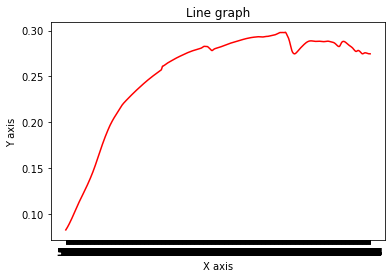

In [45]:
plt.title("Line graph") 
plt.xlabel("X axis") 
plt.ylabel("Y axis") 
plt.plot(row1, r, color ="red") 
plt.show()